In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [2]:
os.chdir('..')

In [3]:
import pickle

from hydra import compose, initialize
from omegaconf import OmegaConf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch

from tqdm.notebook import tqdm

from src.preprocessing.new_data_preprop import preprocessing
from src.datamodules.autoencoder import AEDataModule
from src.networks.lstm import LSTMAE

%load_ext autoreload
%autoreload 2

In [4]:
BEST_MODEL_PATH = 'logs/lstm_new/checkpoints/lstm__embed_dim256_num_layers_1_user_embed_32_masked_pred_0.2.ckpt'

In [5]:
with initialize(config_path='../config', version_base=None):
    cfg = compose(config_name='config')
cfg_preprop = cfg['dataset']
cfg_model = cfg['autoencoder']

In [6]:
seq_data, data_srt = preprocessing(cfg_preprop, return_preproc=True)

In [7]:
seq_data[seq_data['target'] >= .5].count()

user_id            1385
mcc_code           1385
is_income          1385
transaction_amt    1385
target             1385
dtype: int64

In [8]:
datamodule = AEDataModule(
        None,
        seq_data,
        cfg_preprop['user_column'],
        cfg_preprop['mcc_column'],
        cfg_preprop['transaction_amt_column'],
        cfg_model['data_split']['val_size'],
        1,
        cfg_preprop['preproc']['len_max'],
        4,
        .5,
        False,
        binarize=False
    )

In [9]:
datamodule.setup('test')
dataloader = datamodule.test_dataloader()

In [10]:
best_model = LSTMAE.load_from_checkpoint(BEST_MODEL_PATH)

-------------

In [46]:
test_batch = next(iter(dataloader))

In [67]:
test_batch

(tensor([1]),
 tensor([[1, 2, 2, 3, 1, 4, 5, 1, 4, 1, 6, 1, 2, 1, 4, 4, 1, 2, 7, 1, 4]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[5.8891, 4.9223, 4.9334, 5.7349, 4.8939, 4.1497, 7.4026, 7.3118, 5.1768,
          4.5548, 6.3328, 5.2975, 6.1319, 4.7295, 5.1310, 3.5500, 5.2789, 4.5874,
          5.0824, 6.0758, 4.0711]]),
 tensor([21]),
 tensor([0.]))

In [68]:
with torch.no_grad():
    _, _, info = best_model.predict_step(test_batch, 0)

In [69]:
info[2]

tensor([[5.8609, 4.9555, 0.7119, 5.4433, 4.8978, 4.1767, 7.4336, 7.2663, 5.1698,
         0.7067, 6.0255, 5.3516, 6.1490, 4.7147, 5.1335, 0.6384, 5.1024, 4.6248,
         5.0834, 6.1425, 4.0124]])

In [70]:
info[0].max(dim=1)

torch.return_types.max(
values=tensor([[14.8715,  3.7612,  7.3432, 19.7937, 14.8605, 18.2636, 14.8708, 14.3482,
         18.2059,  7.4421, 17.5200, 15.0593,  5.0954, 14.7252, 18.2288,  7.0350,
         14.4666,  4.7825,  9.9341, 14.6572, 18.6908]]),
indices=tensor([[ 1,  2,  6,  3,  1,  4,  5,  1,  4, 45,  6,  1,  2,  1,  4, 45,  1,  2,
          7,  1,  4]]))

----------------

In [11]:
if not os.path.exists('data/new_data/results/'):
    os.mkdir('data/new_data/results/')

if not os.path.exists(
    f'data/new_data/results/model_new_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}.npy'
):
    results = np.zeros((len(dataloader), 5), dtype=np.float32)

    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            outputs = best_model.predict_step(batch, i)
            results[i, 0] = batch[-1].cpu().numpy()
            results[i, 1] = outputs[0].cpu().numpy()
            results[i, 2:] = np.array(outputs[1])
    np.save(
        f'data/new_data/results/model_new_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}',
        results
    )
else:
    results = np.load(
        f'data/new_data/results/model_new_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}.npy'
    )


  0%|          | 0/777435 [00:00<?, ?it/s]

In [12]:
results = np.concatenate((seq_data.index.values[:, np.newaxis], results), 1)

In [13]:
results

array([[0.00000000e+00, 0.00000000e+00, 2.17070270e+00, 1.07733941e+00,
        4.28988459e-03, 6.64374888e-01],
       [1.00000000e+00, 0.00000000e+00, 4.01107359e+00, 1.75655603e+00,
        1.12047326e-02, 1.13404429e+00],
       [2.00000000e+00, 4.54545468e-02, 2.09774303e+01, 2.14083791e+00,
        1.72832936e-01, 1.55329943e+00],
       ...,
       [7.96112000e+05, 0.00000000e+00, 8.56700540e-01, 3.92832041e-01,
        7.48117804e-04, 3.89056742e-01],
       [7.96113000e+05, 0.00000000e+00, 6.42968953e-01, 3.94461423e-01,
        8.69399926e-04, 1.61567524e-01],
       [7.96114000e+05, 0.00000000e+00, 1.32107043e+00, 8.72306705e-01,
        1.08773855e-03, 3.39989871e-01]])

In [14]:
anomaly_fraq = np.unique(results[:, 1])

In [15]:
losses = []
for fraq in tqdm(anomaly_fraq):
    losses.append(results[np.argwhere(results[:, 1] == fraq)][:, 0, :])

  0%|          | 0/636 [00:00<?, ?it/s]

In [16]:
losses = np.concatenate(losses)
losses_df = pd.DataFrame(losses, columns=['seq_id', 'anomaly_fraq', 'loss', 'mcc_loss', 'binary_loss', 'amt_loss'])

In [17]:
losses_df['seq_id'] = losses_df['seq_id'].astype(np.int32)
losses_df.set_index('seq_id', inplace=True)

In [18]:
losses_df['loss_sum'] = losses_df['mcc_loss'] + losses_df['binary_loss'] + losses_df['amt_loss']

In [19]:
def make_groups(fraq):
    if fraq < .2:
        return 0
    elif .2 <= fraq < .5:
        return 1
    elif .5 <= fraq < .7:
        return 2
    else:
        return 3
    
losses_df['class'] = losses_df['anomaly_fraq'].apply(make_groups)

In [20]:
agg_df = pd.DataFrame(losses_df.groupby('anomaly_fraq').agg({
    'loss': ['mean', 'std'],
    'mcc_loss': ['mean', 'std'],
    'binary_loss': ['mean', 'std'],
    'amt_loss': ['mean', 'std'],
    'loss_sum': ['mean', 'std']
}))

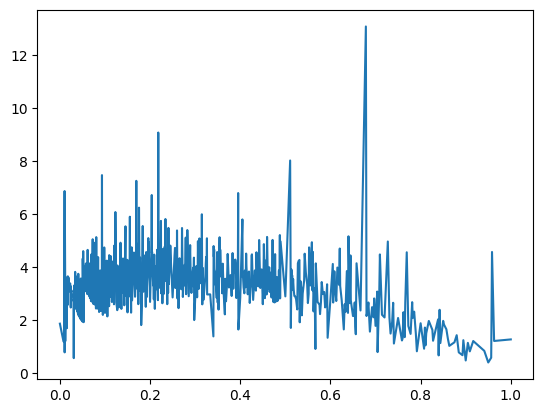

In [21]:
plt.plot(agg_df.index, agg_df['loss_sum']['mean']);

In [22]:
losses_df['loss_sum']

seq_id
0         1.746004
1         2.901805
4         3.018240
6         1.820827
8         6.621923
            ...   
322153    4.572298
337038    1.212963
114185    0.341290
369999    3.049701
625929    0.423888
Name: loss_sum, Length: 777435, dtype: float64

In [23]:
losses_df[losses_df['anomaly_fraq'] >= .5]['loss_sum'].max()

25.46405702084303

In [24]:
from sklearn.metrics import precision_recall_curve

In [25]:
def get_optimum_threshold(y_true, y_pred_proba):
    precisions, recalls, trs = precision_recall_curve(
        y_true, y_pred_proba
    )

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    print(f1_scores.max())
    plt.plot(precisions, recalls)
    plt.show()

    return trs[np.argmax(f1_scores)]

In [28]:
y_true = losses_df['anomaly_fraq'] >= .5

nan


/tmp/ipykernel_19786/1252276051.py:6: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


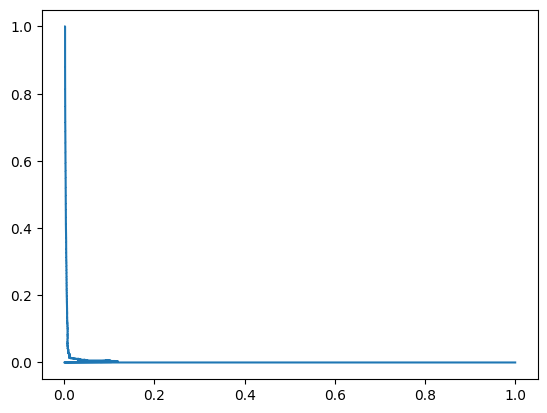

25.75417271256447

In [29]:
get_optimum_threshold(y_true, losses_df['loss_sum'].values)

<BarContainer object of 100 artists>

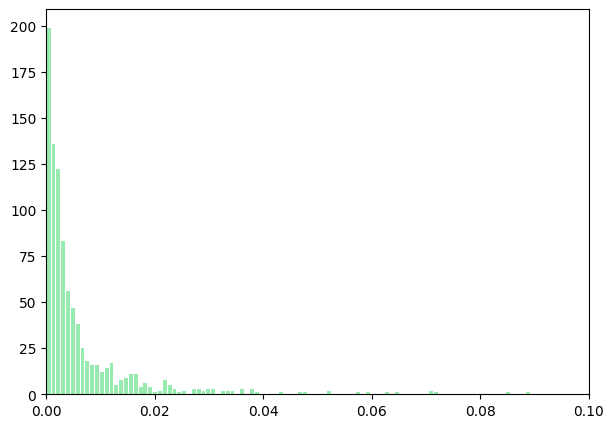

In [119]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_df[losses_df['loss'] < .1]['loss']

# Get histogram
hist, bins = np.histogram(x, bins=100)
# hist = hist / np.sum(hist)

# Threshold frequency
freq = 0 #500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([0, 0.1])
#plt.margins(0.05)
plt.bar(center, hist, align='center', width=width, color = '#33D860', label='normal', alpha=0.5)

<Axes: xlabel='loss_sum'>

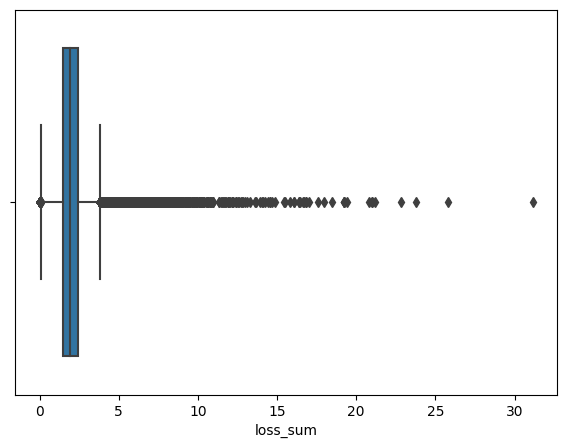

In [120]:
sns.boxplot(x=losses_df['loss_sum'])

Важно! Модель посчитала аномалией набор транзакций с азартными играми (7995 - азартные игры)

user_id - 10682

seq_index - 228781

In [162]:
losses_df[losses_df['loss_sum'] > 20]

,anomaly_fraq,loss,mcc_loss,binary_loss,amt_loss,loss_sum,class
seq_id,,,,,,,
106900,0.0,23.073166,3.290904,0.020689,17.713409,21.025002,0
114053,0.0,27.821541,3.920145,0.020689,21.832542,25.773376,0
168182,0.0,24.901468,3.920145,0.020689,18.912470,22.853303,0
192826,0.0,45.919579,1.038726,0.223977,22.483152,23.745856,0
257582,0.0,22.851784,7.075835,0.020689,13.707093,20.803617,0
375812,0.0,53.783756,0.550530,0.331436,20.089630,20.971596,0
375810,0.5,23.261929,6.309790,0.020701,14.882029,21.212520,2
233111,1.0,33.193787,6.796909,0.020689,24.328026,31.145624,3


In [168]:
seq_data.loc[375812]['mcc_code']

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11])

In [91]:
np.exp(seq_data.iloc[228781]['transaction_amt'])

array([ 22.640741, 109.61357 , 104.53754 ,  46.06033 , 146.29277 ,
       906.0762  , 615.7704  ,  42.93056 ,  45.062397,  53.22185 ,
       106.4844  ,  49.638184,  41.42833 , 108.79991 ,  43.768253,
        91.294975,  26.3708  ,  46.409595,  74.03558 , 299.65143 ,
        52.786674,  55.04169 ,  47.810593,  42.436966,  92.17858 ,
        92.656   ,  90.42266 ,  45.48023 ,  54.039265,  55.719685,
       108.61172 , 108.3005  ,  52.05275 , 104.6088  , 165.3661  ,
        94.977066, 443.53137 ,  93.68741 ,  26.717432,  94.710556])

In [169]:
with open('data/new_data/preprocessed/mcc2id.dict', 'rb') as f:
    with open('data/new_data/preprocessed/user2id.dict', 'rb') as f_1:
        mcc2id = dict(pickle.loads(f.read()))
        user2id = dict(pickle.loads(f_1.read()))

In [170]:
id2mcc = {}
id2user = {}
for k, v in mcc2id.items():
    id2mcc[v] = k
for k, v in user2id.items():
    id2user[v] = k

In [171]:
id2mcc[11]

6011

In [92]:
losses_df[losses_df['loss'] > 1]

,anomaly_fraq,loss,mcc_loss,binary_loss,amt_loss,class
27003,0.000,2.301008,1.652921,1.368638e-06,0.647950,0
152523,0.000,1.026022,1.024961,8.510493e-08,0.001053,0
190996,0.000,1.750069,0.000349,1.661448e-02,0.088273,0
228781,0.000,8.238477,0.000121,8.231580e-02,0.006775,0
336094,0.000,1.584863,1.581835,1.119445e-06,0.002917,0
463958,0.075,1.010901,0.997991,1.396667e-06,0.012770,0
472099,0.100,1.370712,1.360427,1.221470e-06,0.010163,0


In [105]:
seq_data.iloc[152523]['mcc_code']

array([ 4, 27,  4, 17, 11, 11,  1,  1,  1,  4,  4,  4, 29, 27, 10,  1,  4,
        3,  1, 27, 79,  4,  4, 45, 45,  1,  1, 83, 20, 10,  9,  9, 83,  4,
        4, 10,  4,  4,  1, 10])

In [106]:
np.exp(seq_data.iloc[152523]['transaction_amt'])

array([  105.706215,   453.6131  ,   637.0809  ,  2113.6567  ,
        3734.1477  ,  5319.124   ,   577.4285  ,   452.62314 ,
        1194.3778  ,    45.360874,   177.24718 ,    93.19953 ,
        2469.5986  ,   827.13464 ,   207.84126 ,   937.9837  ,
         106.322   , 14444.672   ,   669.1018  ,   465.40512 ,
         848.62244 ,    92.386734,   172.4608  ,    18.137623,
         397.60193 ,   514.62616 ,   627.13965 ,  2120.0928  ,
        1160.5157  ,   179.77898 ,   105.38092 ,   789.8764  ,
         741.5316  ,   512.9007  ,    89.932335,    74.01915 ,
         108.026276,   108.19927 ,   787.0158  ,   214.07022 ])

In [107]:
id2mcc[45]

4121

In [79]:
orig_df = pd.read_parquet('data/new_data/transactions.parquet')

In [88]:
orig_df[(orig_df['user_id'] == id2user[10682]) & (orig_df['mcc_code'] == 7995)]

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
9427255,782283ce1b594f618f8424fe25500c85,7995,48,-40.205284,2020-07-31 06:38:43
9427258,782283ce1b594f618f8424fe25500c85,7995,48,-36.907352,2020-08-01 06:45:14
9427259,782283ce1b594f618f8424fe25500c85,7995,48,-47.200695,2020-08-01 06:53:42
9427260,782283ce1b594f618f8424fe25500c85,7995,48,-36.507774,2020-08-01 07:27:25
9427262,782283ce1b594f618f8424fe25500c85,7995,48,-37.392696,2020-08-01 09:21:51
...,...,...,...,...,...
9428296,782283ce1b594f618f8424fe25500c85,7995,48,-90.043236,2021-01-24 03:22:03
9428297,782283ce1b594f618f8424fe25500c85,7995,48,-211.213870,2021-01-24 04:40:14
9428303,782283ce1b594f618f8424fe25500c85,7995,48,-22.310303,2021-01-26 14:16:54
9428304,782283ce1b594f618f8424fe25500c85,7995,48,-107.449690,2021-01-26 15:33:23
